In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Classification

## Data import and cleaning

In [5]:
df = pd.read_csv('data/cruise_cancellations.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        2000 non-null   int64  
 1   booking_lead_time          2000 non-null   int64  
 2   trip_length                2000 non-null   int64  
 3   cabin_type                 2000 non-null   object 
 4   group_size                 2000 non-null   int64  
 5   loyalty_status             1016 non-null   object 
 6   paid_in_full               2000 non-null   int64  
 7   prior_cruises              2000 non-null   int64  
 8   customer_income            2000 non-null   float64
 9   email_engagement_score     2000 non-null   float64
 10  phone_verified             2000 non-null   int64  
 11  has_insurance              2000 non-null   int64  
 12  on_mailing_list            2000 non-null   int64  
 13  website_visits_last_month  2000 non-null   int64

In [7]:
df.head()

,age,booking_lead_time,trip_length,cabin_type,group_size,loyalty_status,paid_in_full,prior_cruises,customer_income,email_engagement_score,phone_verified,has_insurance,on_mailing_list,website_visits_last_month,survey_participation,preferred_contact_method,travel_history_score,referral_source,gift_certificate_used,canceled
0,56,131,7,Oceanview,5,NaN,1,1,134181.36,0.41,1,0,1,4,No,Phone,62.70,Friend,0,0
1,69,293,5,Oceanview,5,NaN,1,2,104770.24,0.34,1,0,1,1,No,Email,56.59,Friend,0,0
2,46,171,7,Balcony,3,NaN,0,1,109135.01,0.38,1,0,0,3,Yes,Phone,57.58,Ad,0,1
3,32,183,3,Balcony,2,Silver,0,0,80108.53,0.58,0,0,0,2,No,Email,14.75,Search Engine,0,1
4,60,364,10,Oceanview,3,Silver,0,2,73401.55,0.50,1,0,1,3,Partial,Phone,47.49,Ad,0,0


In [8]:
df.isnull().sum()

age                            0
booking_lead_time              0
trip_length                    0
cabin_type                     0
group_size                     0
loyalty_status               984
paid_in_full                   0
prior_cruises                  0
customer_income                0
email_engagement_score         0
phone_verified                 0
has_insurance                  0
on_mailing_list                0
website_visits_last_month      0
survey_participation           0
preferred_contact_method       0
travel_history_score           0
referral_source                0
gift_certificate_used          0
canceled                       0
dtype: int64

In [9]:
df['loyalty_status'].unique()

array([nan, 'Silver', 'Gold', 'Platinum'], dtype=object)

In [11]:
df['loyalty_status'] = df['loyalty_status'].fillna('None')

First, we imported the data and checked that there are 984 null values in the loyalty_status column, which represents visitors with no loyalty status, so we replaced the null value with “None”.

## logistic regression

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [20]:
# 特征列和目标列
features = [
    'age', 'booking_lead_time', 'trip_length', 'cabin_type', 'group_size', 
    'loyalty_status', 'paid_in_full', 'prior_cruises', 'customer_income', 
    'email_engagement_score', 'phone_verified', 'has_insurance', 
    'on_mailing_list', 'website_visits_last_month', 'survey_participation', 
    'preferred_contact_method', 'travel_history_score', 'referral_source', 
    'gift_certificate_used'
]
target = 'canceled'

# 选择特征和目标
X = df[features]
y = df[target]

# 编码分类变量和标准化数值变量
# 定义分类变量列和数值变量列
categorical_cols = ['cabin_type', 'loyalty_status', 'survey_participation', 'preferred_contact_method', 'referral_source']
numeric_cols = ['age', 'booking_lead_time', 'trip_length', 'group_size', 'paid_in_full', 'prior_cruises', 
                'customer_income', 'email_engagement_score', 'phone_verified', 'has_insurance', 
                'on_mailing_list', 'website_visits_last_month', 'travel_history_score', 'gift_certificate_used']

# 使用 Pipeline 处理数值列和分类列
numeric_transformer = 'passthrough'  # 无需标准化 对于数值型特征，不进行处理
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # 使用独热编码处理分类变量 使用 One-Hot 编码categorical variables

# 创建预处理步骤
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 4. 创建逻辑回归模型
lr_model = LogisticRegression(max_iter=1000) # 最大迭代次数为 1000

# 5. 创建管道，将预处理和模型训练步骤封装成一个流程
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_model)
])

# 6. 拆分数据集：训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=654)

# 7. 看是否强线性相关
# 设定相关性阈值
threshold = 0.8

# 计算 OneHot 编码后的特征的相关性
X_train_transformed = preprocessor.fit_transform(X_train)
corr_matrix = pd.DataFrame(X_train_transformed).corr()

# 创建一个空的列表用于存储相关性较高的特征对
high_corr_pairs = []

# 遍历相关性矩阵中的每一对特征
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            # 如果相关性高于阈值，添加到列表中
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# 打印相关性高的特征对
if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"Feature pair: {pair[0]} and {pair[1]} - Correlation: {pair[2]}")
else:
    print("No significant multicollinearity.\n")


# 8. 训练模型
pipeline.fit(X_train, y_train)


No significant multicollinearity.



/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'booking_lead_time',
                                                   'trip_length', 'group_size',
                                                   'paid_in_full',
                                                   'prior_cruises',
                                                   'customer_income',
                                                   'email_engagement_score',
                                                   'phone_verified',
                                                   'has_insurance',
                                                   'on_mailing_list',
                                                   'website_visits_last_month',
                                                   'travel_history_score',
                                                   'gift_certificate_used']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cabin_type',
                                                   'loyalty_status',
                                                   'survey_participation',
                                                   'preferred_contact_method',
                                                   'referral_source'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

For the purpose of classification, we build a logistic regression model to predict whether a cruise booking will be canceled, using the loyalty_status column as the target variable and the other columns as features.  As we noticed before, there're different type of variables in features, so we separate it into categorical_cols and numeric_cols. Categorical features are one-hot encoded, while numerical features remain unchanged. Using Pipeline and ColumnTransformer, We created a streamlined preprocessing and modeling workflow. It splits the data into training and testing sets and checks for multicollinearity among transformed features by analyzing their correlation matrix. Finally, the full pipeline is trained on the training dataset.

In [21]:
# 9. 预测结果并评估模型
y_pred = pipeline.predict(X_test)

# 输出准确率和分类报告
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82       284
           1       0.55      0.21      0.30       116

    accuracy                           0.72       400
   macro avg       0.64      0.57      0.56       400
weighted avg       0.68      0.72      0.67       400



As we can see, the model's accuracy is 0.72. It looks good that the model is 72% correct overall. For those visitors whose booking was canceled, the recall is 0.21, which means that Only about 1/5 of the customers who would cancel are identified. And for those visitors who won't cancle their booking, the recall is 0.93, means that the model accurately identifies the vast majority of customers who will complete the booking.

In [23]:
# 特征列和目标列
features = [
    'age', 'booking_lead_time', 'trip_length', 'cabin_type', 'group_size', 
    'loyalty_status', 'paid_in_full', 'prior_cruises', 'customer_income', 
    'email_engagement_score', 'phone_verified', 'has_insurance', 
    'on_mailing_list', 'website_visits_last_month', 'survey_participation', 
    'preferred_contact_method', 'travel_history_score', 'referral_source', 
    'gift_certificate_used'
]
target = 'canceled'

# 选择特征和目标
X = df[features]
y = df[target]

# 编码分类变量和标准化数值变量
# 定义分类变量列和数值变量列
categorical_cols = ['cabin_type', 'loyalty_status', 'survey_participation', 'preferred_contact_method', 'referral_source']
numeric_cols = ['age', 'booking_lead_time', 'trip_length', 'group_size', 'paid_in_full', 'prior_cruises', 
                'customer_income', 'email_engagement_score', 'phone_verified', 'has_insurance', 
                'on_mailing_list', 'website_visits_last_month', 'travel_history_score', 'gift_certificate_used']

# 使用 Pipeline 处理数值列和分类列
numeric_transformer = 'passthrough'  # 无需标准化 对于数值型特征，不进行处理
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # 使用独热编码处理分类变量 使用 One-Hot 编码categorical variables

# 创建预处理步骤
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 4. 创建逻辑回归模型
lr_balanced_model = LogisticRegression(max_iter=1000, class_weight='balanced') # 最大迭代次数为 1000, 使用类权重

# 5. 创建管道，将预处理和模型训练步骤封装成一个流程
pipeline_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_balanced_model)
])

# 6. 拆分数据集：训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=654)

# 7. 看是否强线性相关
# 设定相关性阈值
threshold = 0.8

# 计算 OneHot 编码后的特征的相关性
X_train_transformed = preprocessor.fit_transform(X_train)
corr_matrix = pd.DataFrame(X_train_transformed).corr()

# 创建一个空的列表用于存储相关性较高的特征对
high_corr_pairs = []

# 遍历相关性矩阵中的每一对特征
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            # 如果相关性高于阈值，添加到列表中
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# 打印相关性高的特征对
if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"Feature pair: {pair[0]} and {pair[1]} - Correlation: {pair[2]}")
else:
    print("No significant multicollinearity.\n")


# 8. 训练模型
pipeline_balanced.fit(X_train, y_train)

# 9. 预测结果并评估模型
y_pred = pipeline_balanced.predict(X_test)

# 输出准确率和分类报告
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

No significant multicollinearity.

Accuracy: 0.6925

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76       284
           1       0.48      0.72      0.58       116

    accuracy                           0.69       400
   macro avg       0.67      0.70      0.67       400
weighted avg       0.75      0.69      0.71       400



/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# 普通模型管道
pipeline_default = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr_model)
])

# 平衡权重模型管道
pipeline_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr_balanced_model)
])

# 拟合 & 预测
pipeline_default.fit(X_train, y_train)
y_pred_default = pipeline_default.predict(X_test)

pipeline_balanced.fit(X_train, y_train)
y_pred_balanced = pipeline_balanced.predict(X_test)

# 输出对比结果
print("==== Default Logistic Regression ====")
print(classification_report(y_test, y_pred_default))

print("==== Balanced Logistic Regression ====")
print(classification_report(y_test, y_pred_balanced))


==== Default Logistic Regression ====
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       284
           1       0.55      0.21      0.30       116

    accuracy                           0.72       400
   macro avg       0.64      0.57      0.56       400
weighted avg       0.68      0.72      0.67       400

==== Balanced Logistic Regression ====
              precision    recall  f1-score   support

           0       0.86      0.68      0.76       284
           1       0.48      0.72      0.58       116

    accuracy                           0.69       400
   macro avg       0.67      0.70      0.67       400
weighted avg       0.75      0.69      0.71       400



/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Because our main purpose is to know what kinds of passengers are most likely to cancel, and the 0.21 recall is obviously not good enough. So we used logistic regression with class_weight='balanced' to handle this. From the results, we can see that the recognition ability of the new model for “Cancel (Class 1)” increases from 21% to 72%, which is a significant improvement. Although the accuracy decreases slightly, the F1-score improves significantly from 0.30 to 0.58, which indicates that the new model is more reliable.

## Random Forest

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# 1. 定义随机森林分类器
rf_model = RandomForestClassifier(n_estimators=100, random_state=654)

# 2. 创建新的 Pipeline（使用同样的 preprocessor）
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# 3. 拆分数据集（如果你之前已经拆好了 X_train 和 y_train，可以跳过这一步）
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=654)

# 4. 训练模型
rf_pipeline.fit(X_train, y_train)

# 5. 预测
y_pred_rf = rf_pipeline.predict(X_test)

# 6. 输出结果
print("🎯 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred_rf))


🎯 Random Forest Accuracy: 0.72

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.96      0.83       284
           1       0.57      0.14      0.22       116

    accuracy                           0.72       400
   macro avg       0.65      0.55      0.53       400
weighted avg       0.68      0.72      0.65       400



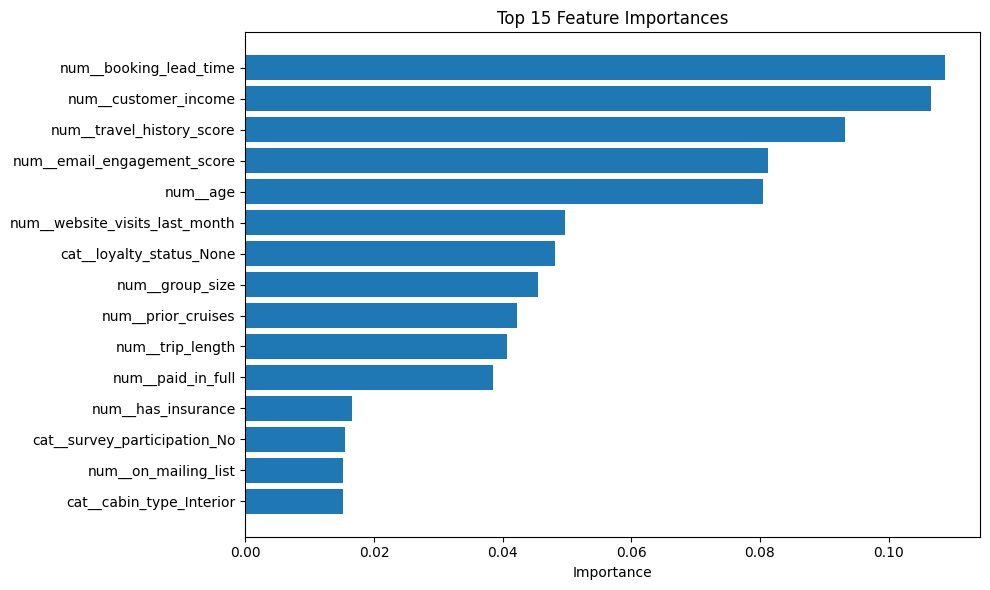

In [114]:
import matplotlib.pyplot as plt

# 获取特征名（处理过的）
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 获取特征重要性
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# 可视化前 15 个重要特征
indices = importances.argsort()[::-1][:15]
plt.figure(figsize=(10,6))
plt.title("Top 15 Feature Importances")
plt.barh(range(len(indices)), importances[indices][::-1], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices][::-1])
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


🌳 最佳树是第 78 棵，准确率：0.7000


/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26869 (\N{CJK UNIFIED IDEOGRAPH-68F5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26641 (\N{CJK UNIFIED IDEOGRAPH-6811}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/p

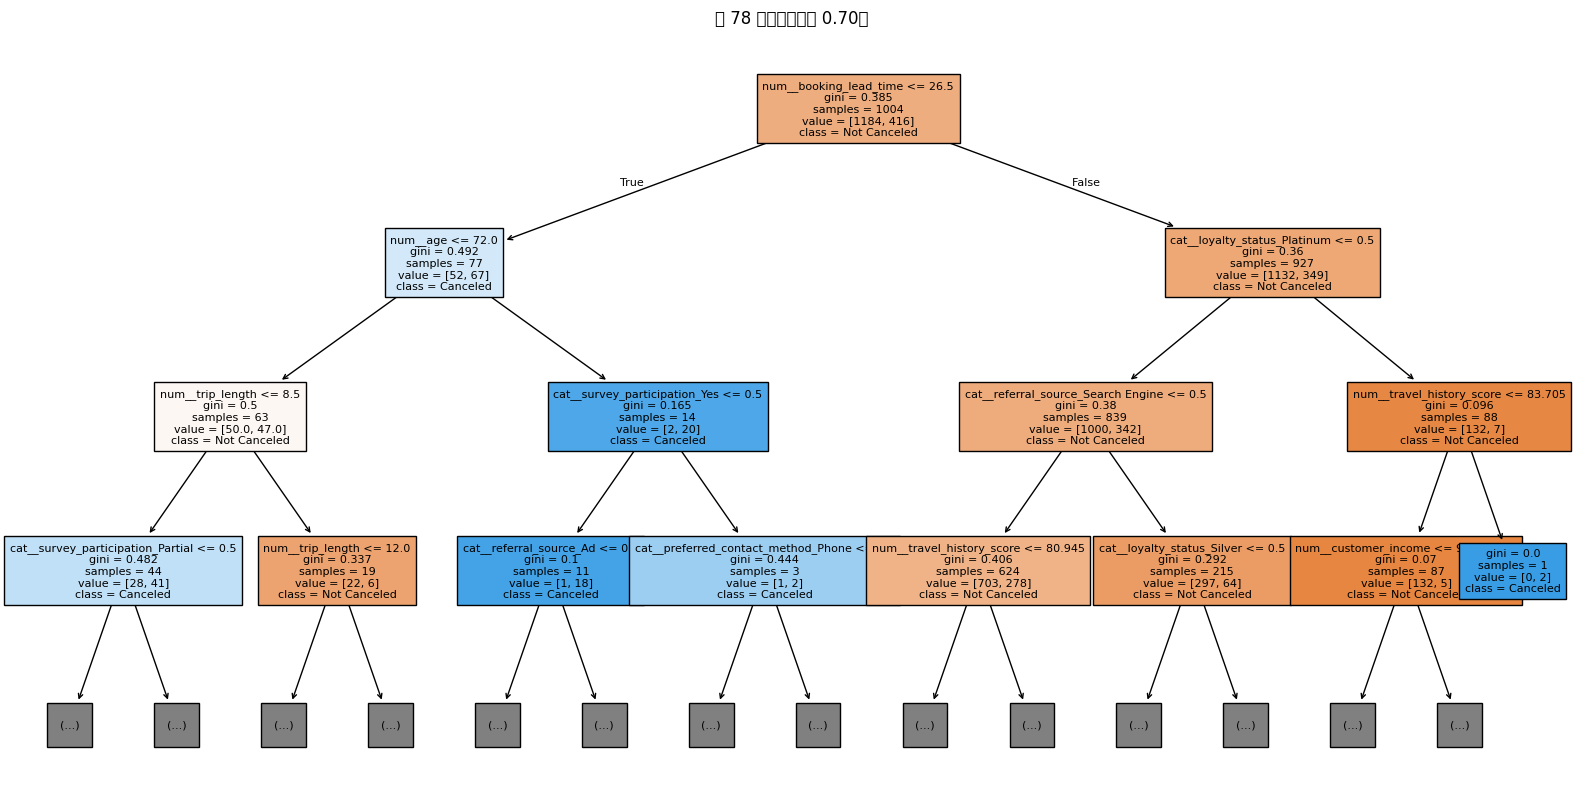

In [116]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# 获取预处理后的训练集 & 测试集
X_test_transformed = preprocessor.transform(X_test)

# 获取所有树
trees = rf_pipeline.named_steps['classifier'].estimators_

# 找出在测试集上表现最好的那棵树
best_tree = None
best_accuracy = 0
best_index = -1

for i, tree in enumerate(trees):
    y_pred_tree = tree.predict(X_test_transformed)
    acc = accuracy_score(y_test, y_pred_tree)
    if acc > best_accuracy:
        best_accuracy = acc
        best_tree = tree
        best_index = i

print(f"🌳 最佳树是第 {best_index} 棵，准确率：{best_accuracy:.4f}")

# 可视化这棵树（前 3 层）
feature_names = preprocessor.get_feature_names_out()
plt.figure(figsize=(20, 10))
plot_tree(best_tree,
          feature_names=feature_names,
          class_names=['Not Canceled', 'Canceled'],
          filled=True,
          max_depth=3,
          fontsize=8)
plt.title(f"第 {best_index} 棵树（准确率 {best_accuracy:.2f}）")
plt.show()


## Comparison of models

/home/ethanchen/AD654-Sp25A3-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📌 Logistic Regression
Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       284
           1       0.55      0.21      0.30       116

    accuracy                           0.72       400
   macro avg       0.64      0.57      0.56       400
weighted avg       0.68      0.72      0.67       400

AUC: 0.7702768334142788

📌 Random Forest
Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.73      0.96      0.83       284
           1       0.57      0.14      0.22       116

    accuracy                           0.72       400
   macro avg       0.65      0.55      0.53       400
weighted avg       0.68      0.72      0.65       400

AUC: 0.717323336571151


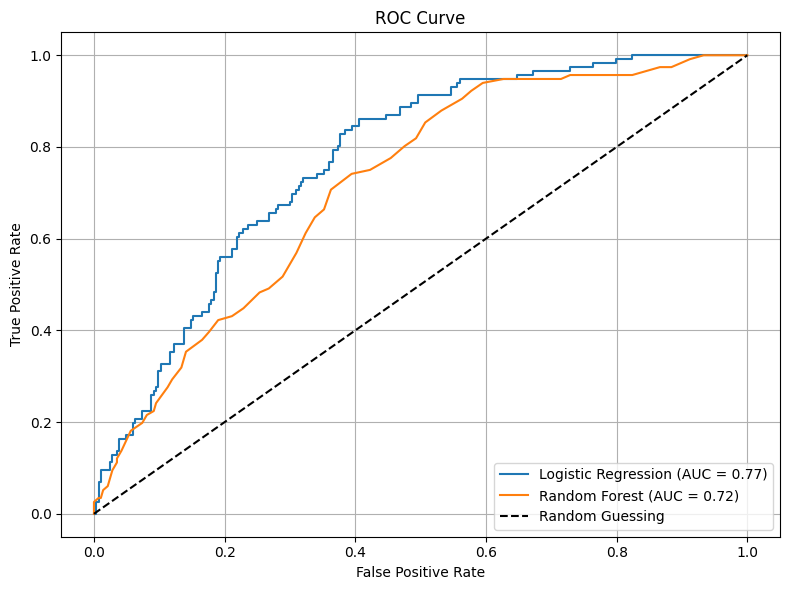

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 定义两个模型
lr_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, random_state=654)

# 创建两个 pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_model)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# 拟合两个模型
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# 预测
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

# 预测概率（用于 ROC 和 AUC）
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# 输出准确率和分类报告
print("📌 Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, y_proba_lr))

print("\n📌 Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_proba_rf))

# 绘制 ROC 曲线
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_lr)))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_rf)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Strategic Memo